In [1255]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [1256]:
df = pd.read_csv("C:\\Users\\joaov\\Documents\\Whisky Casks ETL\\gold\\casks_database__casks_valuation.csv")
# df

# Inflation Adjustment

In [1257]:
# Transforms date columns to datetime format

df['auction_date'] = pd.to_datetime(df['auction_date'], format='%Y-%m-%d')
# df['year'] = df['auction_date'].dt.year
# df['month'] = df['auction_date'].dt.month
# df

In [1258]:
df.sort_values('auction_date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

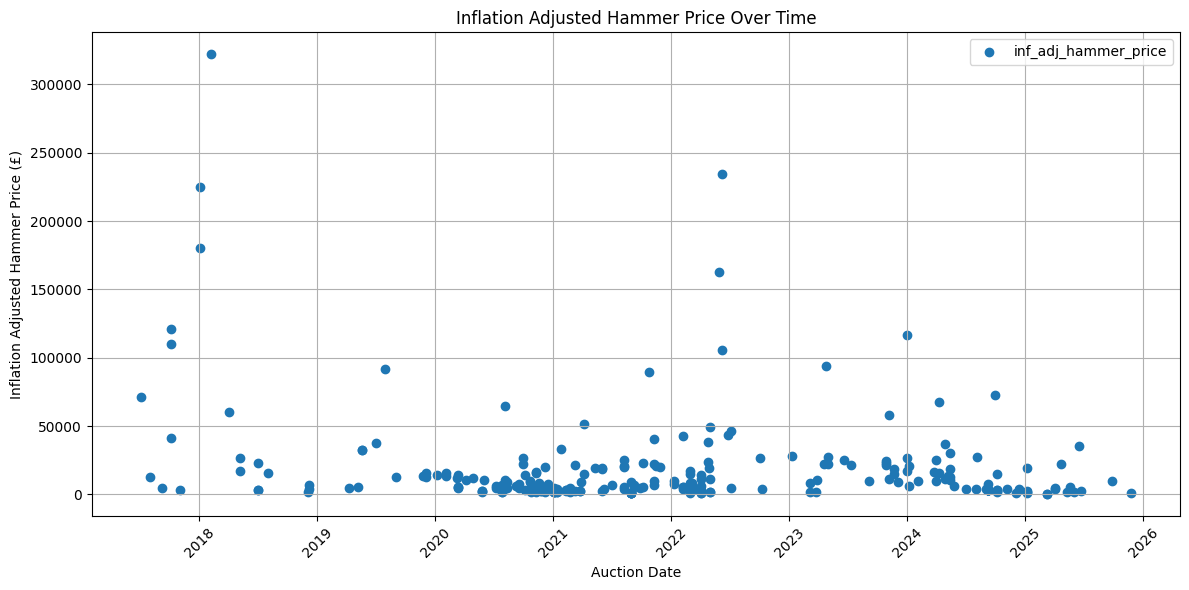

In [1259]:
plt.figure(figsize=(12, 6))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Data preparation

In [1260]:
df.isnull().sum()

auction_date                                             0
distillery                                               1
region                                                   0
country                                                  0
strength                                                 0
rla                                                      0
bulk_litres                                              0
distillery_status                                       15
cask_type                                               20
cask_filling                                           129
previous_spirit                                         14
age                                                      0
bottles_at_cask_strength                                 0
volume_12m                                               0
inf_adj_hammer_price                                     0
inf_adj_hammer_price_per_bottle_at_cask_strength         0
inf_adj_hammer_price_per_litre_of_alcohol               

In [1261]:
# Drop unused columns
df.drop(columns=['inf_adj_hammer_price_per_bottle_at_cask_strength'], inplace=True)

In [1262]:
# Drop columns with too much NaN values
df.drop(columns=['cask_filling', 'distillery_status'], inplace=True)
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,cask_type,previous_spirit,age,bottles_at_cask_strength,volume_12m,inf_adj_hammer_price,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_times_age
0,2025-11-23,Annandale,Lowlands,Scotland,63.5,126.17,198.70,Barrel,Bourbon,4.89,283.860000,92,1375.00,10.90,53.291194
1,2025-09-28,Bruichladdich,Islay,Scotland,53.4,66.75,125.00,Barrel,Bourbon,20.74,178.570000,87,10114.50,151.53,3142.692584
2,2025-06-22,Ardmore,Highlands,Scotland,57.6,92.62,160.80,Barrel,Bourbon,14.47,229.710000,123,2309.94,24.94,360.881363
3,2025-06-16,Springbank,Campbeltown,Scotland,43.3,57.90,131.80,Hogshead,Bourbon,25.46,188.285714,123,35151.19,607.10,15456.809972
4,2025-06-02,Tullibardine,Highlands,Scotland,69.4,109.00,157.06,Barrel,NaN,7.24,224.370000,123,1531.59,14.05,101.731299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2017-10-04,Macallan,Speyside,Scotland,58.9,58.90,141.09,Hogshead,Sherry,23.76,201.560000,10,121292.71,2059.30,48928.943796
255,2017-10-04,Littlemill,Lowlands,Scotland,50.0,50.00,85.00,Barrel,Bourbon,27.76,121.430000,10,41635.80,832.72,23116.196160
256,2017-09-06,Tullibardine,Highlands,Scotland,59.0,59.00,168.00,Barrel,Bourbon,10.68,240.000000,7,4958.21,84.04,897.520047
257,2017-08-02,Bruichladdich,Islay,Scotland,53.9,53.90,162.00,Barrel,Bourbon,13.59,231.430000,6,12498.55,231.88,3151.304165


In [1263]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

auction_date                                           0
distillery                                             0
region                                                 0
country                                                0
strength                                               0
rla                                                    0
bulk_litres                                            0
cask_type                                              0
previous_spirit                                        0
age                                                    0
bottles_at_cask_strength                               0
volume_12m                                             0
inf_adj_hammer_price                                   0
inf_adj_hammer_price_per_litre_of_alcohol              0
inf_adj_hammer_price_per_litre_of_alcohol_times_age    0
dtype: int64

### Outliers filtering

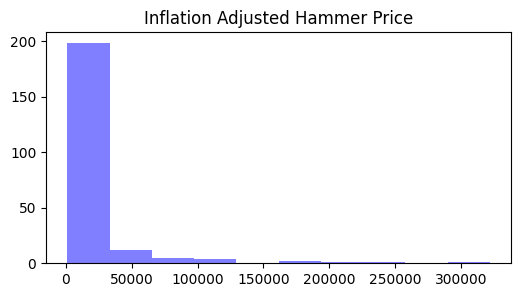

In [1264]:
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

In [1265]:
Q1 = df['inf_adj_hammer_price'].quantile(0.25)
Q3 = df['inf_adj_hammer_price'].quantile(0.75)
IQR = Q3 - Q1

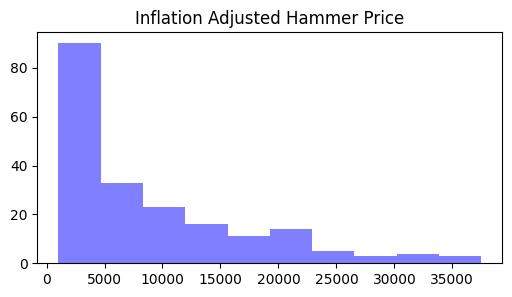

In [1266]:

filtro = (df['inf_adj_hammer_price'] >= (Q1 - 1.5 * IQR)) & (df['inf_adj_hammer_price'] <= (Q3 + 1.5 * IQR))
df = df[filtro].reset_index(drop=True)
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

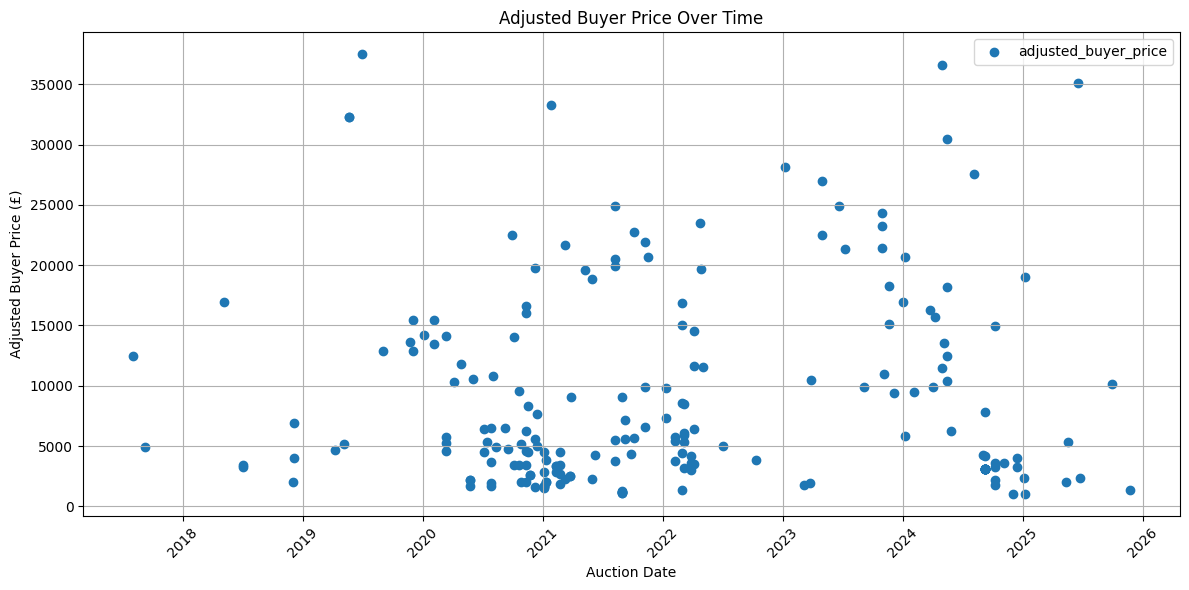

In [1267]:
plt.figure(figsize=(12, 6))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='adjusted_buyer_price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [1268]:
df.drop(columns=['auction_date'], inplace=True)

### Log transformation

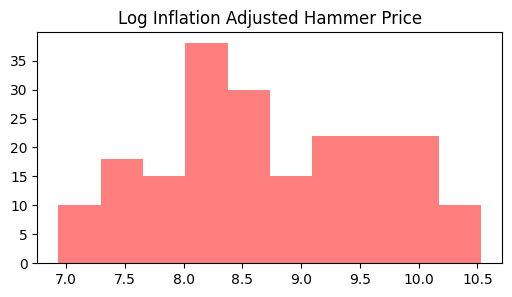

In [1269]:
plt.figure(figsize=(6, 3))
plt.hist(np.log(df['inf_adj_hammer_price']), color='red', alpha=0.5)
plt.title('Log Inflation Adjusted Hammer Price')
plt.show()

### Box-Cox transformation

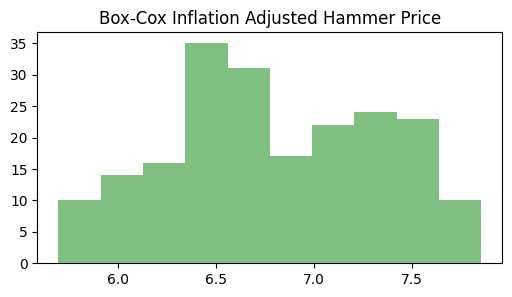

In [1270]:
# Supondo que seus dados estejam em y
y_boxcox, fitted_lambda = boxcox(df['inf_adj_hammer_price'])

plt.figure(figsize=(6, 3))
plt.hist(y_boxcox, color='green', alpha=0.5)
plt.title('Box-Cox Inflation Adjusted Hammer Price')
plt.show()

# Feature selection

In [1271]:
df.columns

Index(['distillery', 'region', 'country', 'strength', 'rla', 'bulk_litres',
       'cask_type', 'previous_spirit', 'age', 'bottles_at_cask_strength',
       'volume_12m', 'inf_adj_hammer_price',
       'inf_adj_hammer_price_per_litre_of_alcohol',
       'inf_adj_hammer_price_per_litre_of_alcohol_times_age'],
      dtype='object')

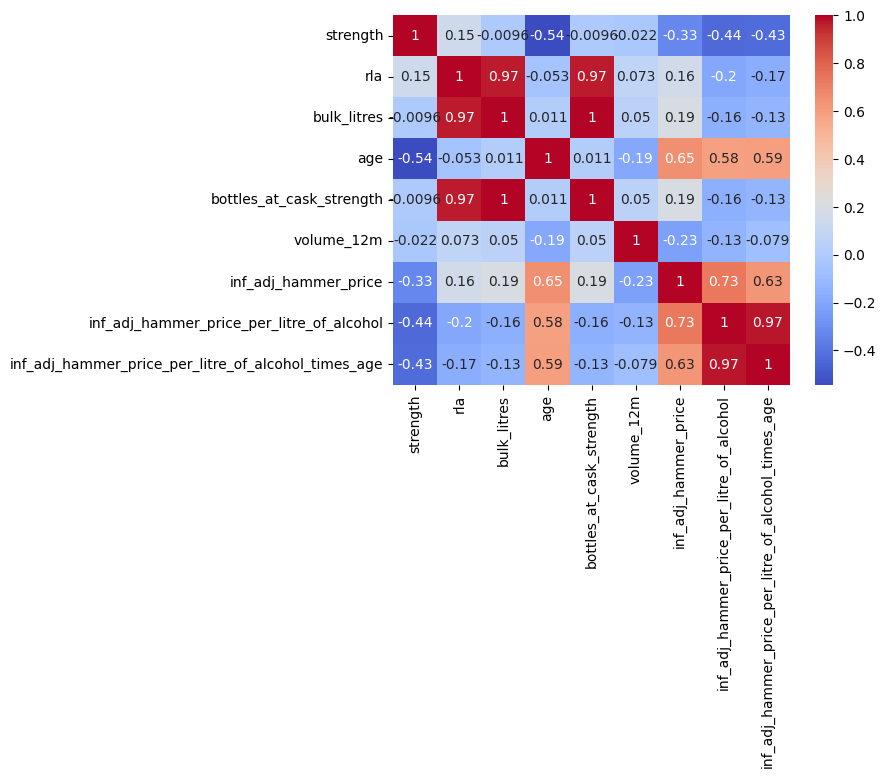

In [1272]:
corr = df.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [1273]:
# Drop column with high correlation to 'Rla'
df_correlation_selection = df.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

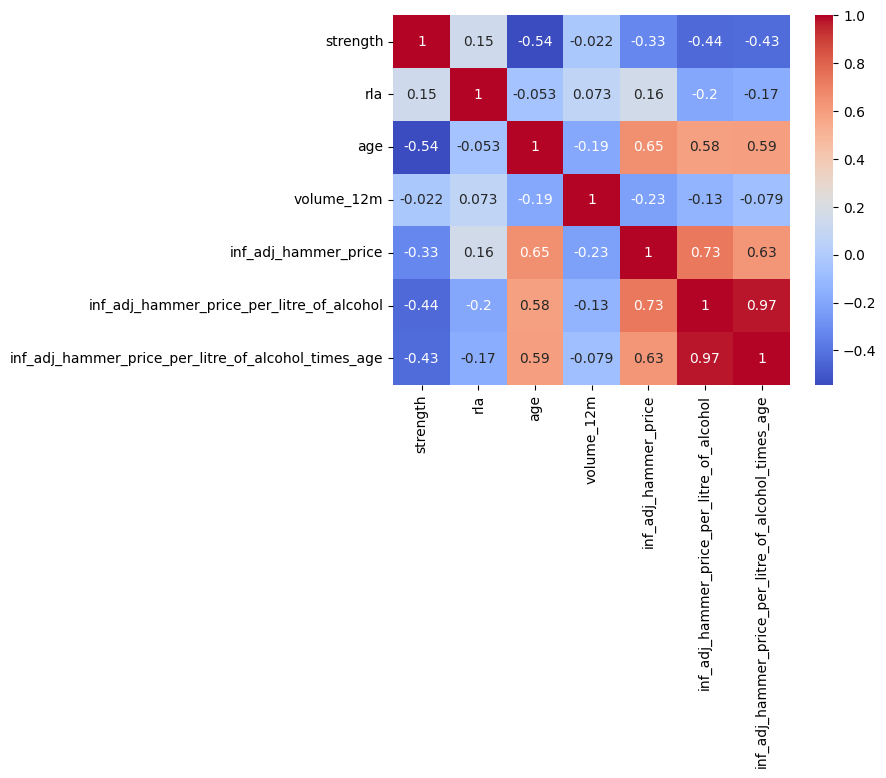

In [1274]:
corr = df_correlation_selection.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### One hot encoding for categorical variables

In [1275]:
df = pd.get_dummies(df, columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], drop_first=True, dtype=int)

In [1276]:
df_correlation_selection = pd.get_dummies(df_correlation_selection,
                                          columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'],
                                          drop_first=True, dtype=int)

In [1277]:
df.columns

Index(['strength', 'rla', 'bulk_litres', 'age', 'bottles_at_cask_strength',
       'volume_12m', 'inf_adj_hammer_price',
       'inf_adj_hammer_price_per_litre_of_alcohol',
       'inf_adj_hammer_price_per_litre_of_alcohol_times_age',
       'distillery_Ardmore', 'distillery_Arran', 'distillery_Aultmore',
       'distillery_Ben Nevis', 'distillery_Benriach', 'distillery_Blair Athol',
       'distillery_Bonnington', 'distillery_Bruichladdich',
       'distillery_Bruichladdich ', 'distillery_Bunnahabhain',
       'distillery_Caol Ila', 'distillery_Caroni', 'distillery_Copper House',
       'distillery_Craigellachie', 'distillery_Dailuaine',
       'distillery_Dalmunach', 'distillery_Dingle', 'distillery_Dufftown',
       'distillery_Fettercairn', 'distillery_Girvan', 'distillery_Glasgow',
       'distillery_Glen Elgin', 'distillery_Glen Garioch',
       'distillery_Glen Moray', 'distillery_Glen Ord', 'distillery_Glen Spey',
       'distillery_Glenallachie', 'distillery_Glenburgie',
     

In [1278]:
df_correlation_selection.columns

Index(['strength', 'rla', 'age', 'volume_12m', 'inf_adj_hammer_price',
       'inf_adj_hammer_price_per_litre_of_alcohol',
       'inf_adj_hammer_price_per_litre_of_alcohol_times_age',
       'distillery_Ardmore', 'distillery_Arran', 'distillery_Aultmore',
       'distillery_Ben Nevis', 'distillery_Benriach', 'distillery_Blair Athol',
       'distillery_Bonnington', 'distillery_Bruichladdich',
       'distillery_Bruichladdich ', 'distillery_Bunnahabhain',
       'distillery_Caol Ila', 'distillery_Caroni', 'distillery_Copper House',
       'distillery_Craigellachie', 'distillery_Dailuaine',
       'distillery_Dalmunach', 'distillery_Dingle', 'distillery_Dufftown',
       'distillery_Fettercairn', 'distillery_Girvan', 'distillery_Glasgow',
       'distillery_Glen Elgin', 'distillery_Glen Garioch',
       'distillery_Glen Moray', 'distillery_Glen Ord', 'distillery_Glen Spey',
       'distillery_Glenallachie', 'distillery_Glenburgie',
       'distillery_Glenfarclas', 'distillery_Glenglassa

# Split train and test data

In [1279]:
x = df.drop(columns=['inf_adj_hammer_price', 'inf_adj_hammer_price_per_litre_of_alcohol_times_age', 'inf_adj_hammer_price_per_litre_of_alcohol'])

In [1280]:
y_standard = df['inf_adj_hammer_price']

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(x, y_standard, test_size=0.20, random_state=42)

# Log transformation
y_train_log_standard = np.log(y_train_standard)

# Box-Cox transformation
y_train_boxcox_standard, fitted_lambda_standard = boxcox(y_train_standard)

scaler_x_train_standard = StandardScaler()
x_train_standard[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_train_standard.fit_transform(x_train_standard[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

scaler_x_test_standard = StandardScaler()
x_test_standard[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_test_standard.fit_transform(x_test[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

x_train_corr_sel_standard = x_train_standard.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])
x_test_corr_sel_standard = x_test_standard.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

In [1281]:
y_per_rla = df['inf_adj_hammer_price_per_litre_of_alcohol']

x_train_per_rla, x_test_per_rla, y_train_per_rla, y_test_per_rla = train_test_split(x, y_per_rla, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla = np.log(y_train_per_rla)

# Box-Cox transformation
y_train_boxcox_per_rla, fitted_lambda_per_rla = boxcox(y_train_per_rla)

scaler_x_train = StandardScaler()
x_train_per_rla[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_train.fit_transform(x_train_per_rla[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

scaler_x_test = StandardScaler()
x_test_per_rla[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_test.fit_transform(x_test_per_rla[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

x_train_corr_sel_per_rla = x_train_per_rla.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])
x_test_corr_sel_per_rla = x_test_per_rla.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

In [1282]:
y_per_rla_times_age = df['inf_adj_hammer_price_per_litre_of_alcohol_times_age']

x_train_per_rla_times_age, x_test_per_rla_times_age, y_train_per_rla_times_age, y_test_per_rla_times_age = train_test_split(x, y_per_rla_times_age, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla_times_age = np.log(y_train_per_rla_times_age)

# Box-Cox transformation
y_train_boxcox_per_rla_times_age, fitted_lambda_per_rla_times_age = boxcox(y_train_per_rla_times_age)

scaler_x_train = StandardScaler()
x_train_per_rla_times_age[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_train.fit_transform(x_train[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

scaler_x_test = StandardScaler()
x_test_per_rla_times_age[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']] = scaler_x_test.fit_transform(x_test[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m']])

x_train_corr_sel_per_rla_times_age = x_train_per_rla_times_age.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])
x_test_corr_sel_per_rla_times_age = x_test_per_rla_times_age.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

In [1283]:
models_metrics = []

# Y = Hammer Price

In [ ]:
y = y_standard

x_train = x_train_standard
x_test = x_test_standard
y_train = y_train_standard
y_test = y_test_standard

# Log transformation
y_train_log = y_train_log_standard

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_standard
fitted_lambda = fitted_lambda_standard

x_train_corr_sel = x_train_corr_sel_standard
x_test_corr_sel = x_test_corr_sel_standard

## ML Models - No transformation

In [1083]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1084]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [1085]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.23
r2: 0.36


,Actual,Predicted,Error
0,9868.56,8370.615687,1497.94
1,2170.00,5852.511280,-3682.51
2,3118.48,4021.887896,-903.41
3,3452.34,8207.688518,-4755.35
4,12857.14,15788.624202,-2931.48
5,18885.38,13071.985309,5813.39
6,23482.50,5442.245500,18040.25
7,10533.15,15108.078621,-4574.93
8,4730.98,4246.345025,484.63
9,9489.80,12419.741800,-2929.94


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
177 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best n_rmse_mean: -4524.45
Best estimator: RandomForestRegressor(max_features='log2', n_estimators=50, random_state=1)


In [1087]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.16
r2: 0.70


,Actual,Predicted,Error
0,9868.56,6822.415200,3046.14
1,2170.00,7192.420400,-5022.42
2,3118.48,4738.700400,-1620.22
3,3452.34,7722.447400,-4270.11
4,12857.14,16606.758800,-3749.62
5,18885.38,14190.756300,4694.62
6,23482.50,12127.681400,11354.82
7,10533.15,11862.270200,-1329.12
8,4730.98,6157.616400,-1426.64
9,9489.80,8795.897800,693.90


### SVM

In [1088]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best n_rmse_mean: -8484.99
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1089]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.74
n_rmse_range: 0.26
r2: 0.18


,Actual,Predicted,Error
0,9868.56,6471.254506,3397.31
1,2170.00,6298.350644,-4128.35
2,3118.48,4946.616248,-1828.14
3,3452.34,7063.839183,-3611.50
4,12857.14,7986.453883,4870.69
5,18885.38,7981.072283,10904.31
6,23482.50,7223.728785,16258.77
7,10533.15,6845.063745,3688.09
8,4730.98,5568.787716,-837.81
9,9489.80,7320.819706,2168.98


### Gradient Boosting

In [1090]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best n_rmse_mean: -4672.42
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10,
                          min_samples_split=10, n_estimators=50,
                          random_state=1)


In [1091]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.50
n_rmse_range: 0.18
r2: 0.62


,Actual,Predicted,Error
0,9868.56,7006.081463,2862.48
1,2170.00,4975.008244,-2805.01
2,3118.48,3261.942379,-143.46
3,3452.34,4564.532702,-1112.19
4,12857.14,24138.871633,-11281.73
5,18885.38,12982.005472,5903.37
6,23482.50,20605.481740,2877.02
7,10533.15,13413.227033,-2880.08
8,4730.98,4940.811503,-209.83
9,9489.80,10639.796643,-1150.00


## ML Models - Log transformation

In [1092]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1093]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [1094]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.22
r2: 0.42


,Actual,Predicted,Error
0,9868.56,7434.514756,2434.05
1,2170.00,5099.224172,-2929.22
2,3118.48,3560.963324,-442.48
3,3452.34,4234.380170,-782.04
4,12857.14,16664.970691,-3807.83
5,18885.38,15184.280524,3701.10
6,23482.50,6602.544240,16879.96
7,10533.15,14003.653412,-3470.50
8,4730.98,4542.784073,188.20
9,9489.80,12252.986527,-2763.19


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
183 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best n_rmse_mean: -0.43
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [1096]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.55
n_rmse_range: 0.19
r2: 0.55


,Actual,Predicted,Error
0,9868.56,6881.393471,2987.17
1,2170.00,5403.877749,-3233.88
2,3118.48,3416.945782,-298.47
3,3452.34,5552.480247,-2100.14
4,12857.14,16462.107926,-3604.97
5,18885.38,5824.898270,13060.48
6,23482.50,8145.385756,15337.11
7,10533.15,10106.328296,426.82
8,4730.98,4853.183021,-122.20
9,9489.80,8481.753077,1008.05


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best n_rmse_mean: -0.42
Best estimator: SVR(C=1)


In [1098]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.16
r2: 0.70


,Actual,Predicted,Error
0,9868.56,6793.787794,3074.77
1,2170.00,4483.569415,-2313.57
2,3118.48,4106.658800,-988.18
3,3452.34,5953.596103,-2501.26
4,12857.14,14102.480798,-1245.34
5,18885.38,9352.486069,9532.89
6,23482.50,11382.116821,12100.38
7,10533.15,11816.309446,-1283.16
8,4730.98,4083.727160,647.25
9,9489.80,10265.490722,-775.69


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.42
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=4,
                          n_estimators=200, random_state=1)


In [1100]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.38
n_rmse_range: 0.13
r2: 0.79


,Actual,Predicted,Error
0,9868.56,7640.726840,2227.83
1,2170.00,2423.981368,-253.98
2,3118.48,3867.968186,-749.49
3,3452.34,3206.369989,245.97
4,12857.14,18035.073761,-5177.93
5,18885.38,14218.372961,4667.01
6,23482.50,13283.148862,10199.35
7,10533.15,6544.774238,3988.38
8,4730.98,4073.087235,657.89
9,9489.80,9552.759280,-62.96


## ML Models - Box-Cox transformation

In [1101]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1102]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [1103]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.22
r2: 0.42


,Actual,Predicted,Error
0,9868.56,7391.615953,2476.94
1,2170.00,5068.916614,-2898.92
2,3118.48,3551.068790,-432.59
3,3452.34,4134.317878,-681.98
4,12857.14,16764.395164,-3907.26
5,18885.38,15326.039817,3559.34
6,23482.50,6611.165980,16871.33
7,10533.15,13940.520956,-3407.37
8,4730.98,4544.546270,186.43
9,9489.80,12272.091334,-2782.29


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.30
Best estimator: RandomForestRegressor(max_features='log2', random_state=1)


In [1105]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.53
n_rmse_range: 0.19
r2: 0.57


,Actual,Predicted,Error
0,9868.56,7039.138262,2829.42
1,2170.00,5469.184756,-3299.18
2,3118.48,3726.802761,-608.32
3,3452.34,4803.255087,-1350.92
4,12857.14,16259.108097,-3401.97
5,18885.38,5852.457184,13032.92
6,23482.50,7798.432820,15684.07
7,10533.15,10698.586628,-165.44
8,4730.98,4710.304221,20.68
9,9489.80,8405.090907,1084.71


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best n_rmse_mean: -0.28
Best estimator: SVR(C=1)


In [1107]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.16
r2: 0.69


,Actual,Predicted,Error
0,9868.56,6339.515921,3529.04
1,2170.00,4530.072531,-2360.07
2,3118.48,4363.232140,-1244.75
3,3452.34,5937.102514,-2484.76
4,12857.14,14705.967233,-1848.83
5,18885.38,9341.401047,9543.98
6,23482.50,11600.709060,11881.79
7,10533.15,11351.036688,-817.89
8,4730.98,3816.862595,914.12
9,9489.80,9744.828982,-255.03


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best n_rmse_mean: -0.30
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200,
                          random_state=1)


In [1109]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.34
n_rmse_range: 0.12
r2: 0.82


,Actual,Predicted,Error
0,9868.56,8629.438057,1239.12
1,2170.00,3834.246324,-1664.25
2,3118.48,3152.743063,-34.26
3,3452.34,4356.178691,-903.84
4,12857.14,16062.733669,-3205.59
5,18885.38,24974.854958,-6089.47
6,23482.50,15103.344664,8379.16
7,10533.15,8671.756670,1861.39
8,4730.98,3913.091385,817.89
9,9489.80,9036.056446,453.74


## ML Models - No transformation - Correlation Selection

In [1110]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1111]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [1112]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.23
r2: 0.37


,Actual,Predicted,Error
0,9868.56,8353.618020,1514.94
1,2170.00,6206.151087,-4036.15
2,3118.48,3616.884173,-498.40
3,3452.34,9830.395985,-6378.06
4,12857.14,16907.683163,-4050.54
5,18885.38,14168.407971,4716.97
6,23482.50,6586.792412,16895.71
7,10533.15,15912.247597,-5379.10
8,4730.98,5024.733960,-293.75
9,9489.80,10844.217941,-1354.42


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
275 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -4323.76
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1114]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.41
n_rmse_range: 0.14
r2: 0.75


,Actual,Predicted,Error
0,9868.56,6857.068350,3011.49
1,2170.00,6446.747800,-4276.75
2,3118.48,4047.502200,-929.02
3,3452.34,6337.213950,-2884.87
4,12857.14,16470.490300,-3613.35
5,18885.38,15631.787425,3253.59
6,23482.50,12664.866650,10817.63
7,10533.15,13903.550350,-3370.40
8,4730.98,5453.777083,-722.80
9,9489.80,10335.766300,-845.97


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best n_rmse_mean: -8535.36
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1116]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.73
n_rmse_range: 0.26
r2: 0.19


,Actual,Predicted,Error
0,9868.56,6337.430490,3531.13
1,2170.00,5752.490641,-3582.49
2,3118.48,4163.832562,-1045.35
3,3452.34,6628.929390,-3176.59
4,12857.14,8409.120379,4448.02
5,18885.38,8789.008963,10096.37
6,23482.50,7248.586597,16233.91
7,10533.15,6785.615263,3747.53
8,4730.98,5346.903756,-615.92
9,9489.80,7043.048863,2446.75


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best n_rmse_mean: -4564.34
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=50,
                          random_state=1)


In [1118]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.47
n_rmse_range: 0.16
r2: 0.67


,Actual,Predicted,Error
0,9868.56,7340.744407,2527.82
1,2170.00,2671.077803,-501.08
2,3118.48,2992.947260,125.53
3,3452.34,4446.240018,-993.90
4,12857.14,21991.248355,-9134.11
5,18885.38,12939.035099,5946.34
6,23482.50,17262.061046,6220.44
7,10533.15,14193.002932,-3659.85
8,4730.98,4589.542050,141.44
9,9489.80,10110.209985,-620.41


## ML Models - Log transformation - Correlation Selection

In [1119]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1120]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [1121]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.22
r2: 0.42


,Actual,Predicted,Error
0,9868.56,7299.755127,2568.80
1,2170.00,5187.490039,-3017.49
2,3118.48,3411.452007,-292.97
3,3452.34,4731.759637,-1279.42
4,12857.14,18385.930950,-5528.79
5,18885.38,17352.009571,1533.37
6,23482.50,7205.394762,16277.11
7,10533.15,14770.587157,-4237.44
8,4730.98,4792.136106,-61.16
9,9489.80,10698.056512,-1208.26


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best n_rmse_mean: -0.42
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [1123]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.49
n_rmse_range: 0.17
r2: 0.63


,Actual,Predicted,Error
0,9868.56,6940.405331,2928.15
1,2170.00,4148.897578,-1978.90
2,3118.48,2966.315028,152.16
3,3452.34,4024.125141,-571.79
4,12857.14,15812.655742,-2955.52
5,18885.38,8622.608876,10262.77
6,23482.50,9254.326879,14228.17
7,10533.15,11807.769840,-1274.62
8,4730.98,4532.565110,198.41
9,9489.80,9912.115254,-422.32


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}
Best n_rmse_mean: -0.41
Best estimator: SVR(C=1, kernel='linear')


In [1125]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.52
n_rmse_range: 0.18
r2: 0.59


,Actual,Predicted,Error
0,9868.56,6168.029321,3700.53
1,2170.00,5438.303004,-3268.30
2,3118.48,3574.417308,-455.94
3,3452.34,4418.112208,-965.77
4,12857.14,18095.995067,-5238.86
5,18885.38,19742.299068,-856.92
6,23482.50,7693.077981,15789.42
7,10533.15,12694.645483,-2161.50
8,4730.98,4867.660576,-136.68
9,9489.80,10824.005895,-1334.21


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.42
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          random_state=1)


In [1127]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.14
r2: 0.76


,Actual,Predicted,Error
0,9868.56,7836.011640,2032.55
1,2170.00,3397.813398,-1227.81
2,3118.48,2739.190377,379.29
3,3452.34,3664.566215,-212.23
4,12857.14,21713.861550,-8856.72
5,18885.38,20920.379687,-2035.00
6,23482.50,11492.488240,11990.01
7,10533.15,10711.506964,-178.36
8,4730.98,4017.004417,713.98
9,9489.80,11325.667203,-1835.87


## ML Models - Box-Cox transformation - Correlation Selection

In [1128]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1129]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [1130]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.22
r2: 0.42


,Actual,Predicted,Error
0,9868.56,7258.420964,2610.14
1,2170.00,5154.632778,-2984.63
2,3118.48,3407.475239,-289.00
3,3452.34,4605.158203,-1152.82
4,12857.14,18551.710707,-5694.57
5,18885.38,17579.551828,1305.83
6,23482.50,7208.749288,16273.75
7,10533.15,14720.768556,-4187.62
8,4730.98,4787.312766,-56.33
9,9489.80,10697.187031,-1207.39


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.28
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1132]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.48
n_rmse_range: 0.17
r2: 0.65


,Actual,Predicted,Error
0,9868.56,6936.418739,2932.14
1,2170.00,4440.809603,-2270.81
2,3118.48,3241.286364,-122.81
3,3452.34,4168.138241,-715.80
4,12857.14,15636.666045,-2779.53
5,18885.38,8910.390028,9974.99
6,23482.50,9995.455714,13487.04
7,10533.15,12988.220693,-2455.07
8,4730.98,4779.015650,-48.04
9,9489.80,9386.712226,103.09


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best n_rmse_mean: -0.28
Best estimator: SVR(C=1)


In [1134]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.46
n_rmse_range: 0.16
r2: 0.68


,Actual,Predicted,Error
0,9868.56,6131.691575,3736.87
1,2170.00,4555.390589,-2385.39
2,3118.48,4384.460917,-1265.98
3,3452.34,6341.481270,-2889.14
4,12857.14,15430.712558,-2573.57
5,18885.38,9761.697327,9123.68
6,23482.50,12046.623028,11435.88
7,10533.15,12186.534477,-1653.38
8,4730.98,4134.132924,596.85
9,9489.80,10329.639732,-839.84


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best n_rmse_mean: -0.29
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=50,
                          random_state=1)


In [1136]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.36
n_rmse_range: 0.13
r2: 0.80


,Actual,Predicted,Error
0,9868.56,8607.026848,1261.53
1,2170.00,4062.171937,-1892.17
2,3118.48,3078.127038,40.35
3,3452.34,3773.971057,-321.63
4,12857.14,21232.727338,-8375.59
5,18885.38,19531.572825,-646.19
6,23482.50,12779.463189,10703.04
7,10533.15,9952.034049,581.12
8,4730.98,4145.659376,585.32
9,9489.80,9831.835709,-342.04


# Y = HP per litre of alcohol

In [1137]:
y = y_per_rla

x_train = x_train_per_rla
x_test = x_test_per_rla
y_train = y_train_per_rla
y_test = y_test_per_rla

# Log transformation
y_train_log = y_train_log_per_rla

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla
fitted_lambda = fitted_lambda_per_rla

x_train_corr_sel = x_train_corr_sel_per_rla
x_test_corr_sel = x_test_corr_sel_per_rla

## ML Models - No transformation - HP per Litre of Alcohol

In [1138]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1139]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [1140]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.16
r2: 0.50


,Actual,Predicted,Error
0,104.87,86.569999,18.30
1,16.01,12.278323,3.73
2,21.27,-1.250726,22.52
3,28.07,48.340915,-20.27
4,181.68,188.710285,-7.03
5,418.84,209.578330,209.26
6,317.63,87.739974,229.89
7,95.58,126.624483,-31.04
8,38.94,5.185380,33.75
9,97.03,120.110013,-23.08


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
293 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -90.82
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1142]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.51


,Actual,Predicted,Error
0,104.87,74.260900,30.61
1,16.01,46.166500,-30.16
2,21.27,27.800200,-6.53
3,28.07,53.192200,-25.12
4,181.68,226.683500,-45.00
5,418.84,271.533800,147.31
6,317.63,129.639200,187.99
7,95.58,115.773800,-20.19
8,38.94,45.102600,-6.16
9,97.03,96.224700,0.81


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best n_rmse_mean: -91.78
Best estimator: SVR(C=10, kernel='linear')


In [1144]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.58
n_rmse_range: 0.14
r2: 0.58


,Actual,Predicted,Error
0,104.87,68.364750,36.51
1,16.01,29.679514,-13.67
2,21.27,7.306216,13.96
3,28.07,46.472842,-18.40
4,181.68,191.219442,-9.54
5,418.84,195.886383,222.95
6,317.63,104.220723,213.41
7,95.58,124.241998,-28.66
8,38.94,29.816419,9.12
9,97.03,97.585075,-0.56


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best n_rmse_mean: -101.85
Best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, min_samples_leaf=4,
                          min_samples_split=10, random_state=1)


In [1146]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.56
n_rmse_range: 0.14
r2: 0.60


,Actual,Predicted,Error
0,104.87,85.756702,19.11
1,16.01,58.811235,-42.80
2,21.27,51.432328,-30.16
3,28.07,56.065426,-28.00
4,181.68,203.622554,-21.94
5,418.84,372.495227,46.34
6,317.63,75.059877,242.57
7,95.58,117.943611,-22.36
8,38.94,66.436311,-27.50
9,97.03,96.355159,0.67


## ML Models - Log transformation - HP per Litre of Alcohol

In [1147]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1148]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [1149]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.51


,Actual,Predicted,Error
0,104.87,69.167745,35.70
1,16.01,27.388740,-11.38
2,21.27,17.353079,3.92
3,28.07,28.304858,-0.23
4,181.68,225.134626,-43.45
5,418.84,298.392223,120.45
6,317.63,84.058919,233.57
7,95.58,106.155106,-10.58
8,38.94,30.356280,8.58
9,97.03,107.155555,-10.13


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
232 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.46
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1151]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.16
r2: 0.49


,Actual,Predicted,Error
0,104.87,62.934187,41.94
1,16.01,32.826554,-16.82
2,21.27,21.919097,-0.65
3,28.07,38.799817,-10.73
4,181.68,208.266998,-26.59
5,418.84,153.596338,265.24
6,317.63,108.761279,208.87
7,95.58,92.384473,3.20
8,38.94,39.740319,-0.80
9,97.03,69.114985,27.92


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.43
Best estimator: SVR(C=1, epsilon=0.2, kernel='linear')


In [1153]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.57
n_rmse_range: 0.14
r2: 0.58


,Actual,Predicted,Error
0,104.87,55.911564,48.96
1,16.01,27.893261,-11.88
2,21.27,19.323432,1.95
3,28.07,26.436706,1.63
4,181.68,250.349890,-68.67
5,418.84,322.474475,96.37
6,317.63,92.211693,225.42
7,95.58,98.673530,-3.09
8,38.94,32.349739,6.59
9,97.03,86.598381,10.43


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best n_rmse_mean: -0.45
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=4,
                          min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1155]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.52
n_rmse_range: 0.13
r2: 0.66


,Actual,Predicted,Error
0,104.87,70.728771,34.14
1,16.01,16.628068,-0.62
2,21.27,18.138606,3.13
3,28.07,20.099421,7.97
4,181.68,212.835610,-31.16
5,418.84,490.669095,-71.83
6,317.63,102.257258,215.37
7,95.58,70.929881,24.65
8,38.94,30.214469,8.73
9,97.03,81.761770,15.27


## ML Models - Box-Cox transformation - HP per Litre of Alcohol

In [1156]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1157]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [1158]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.51


,Actual,Predicted,Error
0,104.87,67.795135,37.07
1,16.01,27.835478,-11.83
2,21.27,18.055070,3.21
3,28.07,27.607227,0.46
4,181.68,239.069365,-57.39
5,418.84,349.712766,69.13
6,317.63,84.069303,233.56
7,95.58,102.490810,-6.91
8,38.94,31.212628,7.73
9,97.03,105.652905,-8.62


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best n_rmse_mean: -0.26
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
219 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [1160]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.69
n_rmse_range: 0.17
r2: 0.39


,Actual,Predicted,Error
0,104.87,65.291614,39.58
1,16.01,35.564797,-19.55
2,21.27,22.153878,-0.88
3,28.07,44.069662,-16.00
4,181.68,206.876357,-25.20
5,418.84,123.708177,295.13
6,317.63,82.106962,235.52
7,95.58,99.786394,-4.21
8,38.94,39.207253,-0.27
9,97.03,64.187541,32.84


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best n_rmse_mean: -0.26
Best estimator: SVR(C=1)


In [1162]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.46


,Actual,Predicted,Error
0,104.87,53.476537,51.39
1,16.01,32.150248,-16.14
2,21.27,26.262978,-4.99
3,28.07,38.893416,-10.82
4,181.68,210.851345,-29.17
5,418.84,119.794649,299.05
6,317.63,142.258253,175.37
7,95.58,85.200944,10.38
8,38.94,26.247477,12.69
9,97.03,80.010581,17.02


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best n_rmse_mean: -0.25
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=4,
                          min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1164]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.59
n_rmse_range: 0.15
r2: 0.56


,Actual,Predicted,Error
0,104.87,62.868237,42.00
1,16.01,14.746941,1.26
2,21.27,16.826158,4.44
3,28.07,22.173903,5.90
4,181.68,184.429230,-2.75
5,418.84,516.343839,-97.50
6,317.63,76.823877,240.81
7,95.58,77.203522,18.38
8,38.94,27.504088,11.44
9,97.03,65.570693,31.46


## ML Models - No transformation - Correlation Selection - HP per Litre of Alcohol

In [1165]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1166]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [1167]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.60
n_rmse_range: 0.15
r2: 0.55


,Actual,Predicted,Error
0,104.87,83.102617,21.77
1,16.01,14.908504,1.10
2,21.27,-8.707737,29.98
3,28.07,66.590077,-38.52
4,181.68,205.443330,-23.76
5,418.84,233.080099,185.76
6,317.63,102.340860,215.29
7,95.58,135.339523,-39.76
8,38.94,13.970271,24.97
9,97.03,97.059617,-0.03


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
256 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -89.26
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1169]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.66
n_rmse_range: 0.16
r2: 0.45


,Actual,Predicted,Error
0,104.87,76.428200,28.44
1,16.01,41.979350,-25.97
2,21.27,24.869150,-3.60
3,28.07,50.321650,-22.25
4,181.68,206.669450,-24.99
5,418.84,245.197400,173.64
6,317.63,134.743550,182.89
7,95.58,118.864550,-23.28
8,38.94,46.406710,-7.47
9,97.03,95.023200,2.01


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best n_rmse_mean: -91.69
Best estimator: SVR(C=10, kernel='linear')


In [1171]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.57
n_rmse_range: 0.14
r2: 0.58


,Actual,Predicted,Error
0,104.87,68.523261,36.35
1,16.01,29.062925,-13.05
2,21.27,6.558780,14.71
3,28.07,45.955823,-17.89
4,181.68,193.318834,-11.64
5,418.84,199.665862,219.17
6,317.63,105.805436,211.82
7,95.58,123.558541,-27.98
8,38.94,29.342382,9.60
9,97.03,98.132938,-1.10


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best n_rmse_mean: -101.46
Best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, min_samples_leaf=4,
                          min_samples_split=10, random_state=1)


In [1173]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.55
n_rmse_range: 0.14
r2: 0.61


,Actual,Predicted,Error
0,104.87,86.234221,18.64
1,16.01,58.586052,-42.58
2,21.27,51.386605,-30.12
3,28.07,55.374221,-27.30
4,181.68,206.106762,-24.43
5,418.84,372.481663,46.36
6,317.63,74.585702,243.04
7,95.58,114.626190,-19.05
8,38.94,66.877387,-27.94
9,97.03,96.348831,0.68


## ML Models - Log transformation - Correlation Selection - HP per Litre of Alcohol

In [1174]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1175]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [1176]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.61
n_rmse_range: 0.15
r2: 0.53


,Actual,Predicted,Error
0,104.87,66.666990,38.20
1,16.01,27.432960,-11.42
2,21.27,16.494615,4.78
3,28.07,30.520955,-2.45
4,181.68,248.217646,-66.54
5,418.84,355.034063,63.81
6,317.63,90.351267,227.28
7,95.58,109.797937,-14.22
8,38.94,31.484755,7.46
9,97.03,93.920462,3.11


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.45
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1178]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.16
r2: 0.47


,Actual,Predicted,Error
0,104.87,71.825353,33.04
1,16.01,33.298567,-17.29
2,21.27,22.687303,-1.42
3,28.07,37.361161,-9.29
4,181.68,194.751039,-13.07
5,418.84,137.152441,281.69
6,317.63,103.534557,214.10
7,95.58,102.444033,-6.86
8,38.94,41.288282,-2.35
9,97.03,95.753489,1.28


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.43
Best estimator: SVR(C=1, epsilon=0.2, kernel='linear')


In [1180]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.57
n_rmse_range: 0.14
r2: 0.58


,Actual,Predicted,Error
0,104.87,56.011300,48.86
1,16.01,27.964826,-11.95
2,21.27,19.353254,1.92
3,28.07,26.496573,1.57
4,181.68,249.658560,-67.98
5,418.84,321.487750,97.35
6,317.63,92.389732,225.24
7,95.58,98.539455,-2.96
8,38.94,32.349635,6.59
9,97.03,86.711472,10.32


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best n_rmse_mean: -0.44
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1182]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.67
n_rmse_range: 0.17
r2: 0.43


,Actual,Predicted,Error
0,104.87,68.775552,36.09
1,16.01,22.408477,-6.40
2,21.27,22.613134,-1.34
3,28.07,26.021704,2.05
4,181.68,210.653605,-28.97
5,418.84,227.357215,191.48
6,317.63,130.183679,187.45
7,95.58,72.097100,23.48
8,38.94,30.178676,8.76
9,97.03,74.476355,22.55


## ML Models - Box-Cox transformation - Correlation Selection - HP per Litre of Alcohol

In [1183]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1184]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [1185]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.16
r2: 0.50


,Actual,Predicted,Error
0,104.87,65.409000,39.46
1,16.01,27.828262,-11.82
2,21.27,17.350009,3.92
3,28.07,29.259898,-1.19
4,181.68,265.871740,-84.19
5,418.84,429.747036,-10.91
6,317.63,89.864234,227.77
7,95.58,105.653629,-10.07
8,38.94,32.117783,6.82
9,97.03,93.079366,3.95


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
190 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.26
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1187]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.47


,Actual,Predicted,Error
0,104.87,73.380513,31.49
1,16.01,31.942047,-15.93
2,21.27,22.703460,-1.43
3,28.07,34.591813,-6.52
4,181.68,193.105378,-11.43
5,418.84,138.224125,280.62
6,317.63,100.379354,217.25
7,95.58,102.033928,-6.45
8,38.94,35.669242,3.27
9,97.03,90.363445,6.67


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best n_rmse_mean: -0.25
Best estimator: SVR(C=1)


In [1189]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.66
n_rmse_range: 0.16
r2: 0.45


,Actual,Predicted,Error
0,104.87,53.194911,51.68
1,16.01,30.303323,-14.29
2,21.27,24.510150,-3.24
3,28.07,40.202813,-12.13
4,181.68,218.128000,-36.45
5,418.84,113.519319,305.32
6,317.63,142.796360,174.83
7,95.58,91.384113,4.20
8,38.94,27.040953,11.90
9,97.03,86.217012,10.81


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best n_rmse_mean: -0.25
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=10, random_state=1)


In [1191]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.53
n_rmse_range: 0.13
r2: 0.64


,Actual,Predicted,Error
0,104.87,69.977834,34.89
1,16.01,19.965746,-3.96
2,21.27,18.586330,2.68
3,28.07,24.215763,3.85
4,181.68,184.514236,-2.83
5,418.84,266.278895,152.56
6,317.63,107.008314,210.62
7,95.58,64.101090,31.48
8,38.94,31.089750,7.85
9,97.03,76.575811,20.45


# Y = HP per litre of alcohol Times Age

In [1192]:
y = y_per_rla_times_age

x_train = x_train_per_rla_times_age
x_test = x_test_per_rla_times_age
y_train = y_train_per_rla_times_age
y_test = y_test_per_rla_times_age

# Log transformation
y_train_log = y_train_log_per_rla_times_age

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla_times_age
fitted_lambda = fitted_lambda_per_rla_times_age

x_train_corr_sel = x_train_corr_sel_per_rla_times_age
x_test_corr_sel = x_test_corr_sel_per_rla_times_age

## ML Models - No transformation - HP per Litre of Alcohol Times Age

In [1193]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1194]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [1195]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.95
n_rmse_range: 0.11
r2: 0.61


,Actual,Predicted,Error
0,1363.350478,1072.097800,291.25
1,224.090876,308.647704,-84.56
2,78.493801,-453.706011,532.20
3,364.911131,534.902442,-169.99
4,2906.800057,2951.447819,-44.65
5,12736.846436,5535.092870,7201.75
6,5498.202015,1776.704969,3721.50
7,764.656987,1018.170662,-253.51
8,198.584346,-568.825278,767.41
9,1308.001063,1665.948979,-357.95


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best n_rmse_mean: -2210.62
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [1197]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.15
n_rmse_range: 0.13
r2: 0.42


,Actual,Predicted,Error
0,1363.350478,866.203687,497.15
1,224.090876,403.133887,-179.04
2,78.493801,79.471222,-0.98
3,364.911131,547.693655,-182.78
4,2906.800057,3667.569249,-760.77
5,12736.846436,4219.155631,8517.69
6,5498.202015,2229.373270,3268.83
7,764.656987,1345.619518,-580.96
8,198.584346,317.970544,-119.39
9,1308.001063,1160.625781,147.38


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best n_rmse_mean: -2780.52
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1199]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.20
n_rmse_range: 0.14
r2: 0.37


,Actual,Predicted,Error
0,1363.350478,1166.934546,196.42
1,224.090876,878.464625,-654.37
2,78.493801,-54.471432,132.97
3,364.911131,994.193895,-629.28
4,2906.800057,2235.585298,671.21
5,12736.846436,3002.027931,9734.82
6,5498.202015,1765.380366,3732.82
7,764.656987,1194.043817,-429.39
8,198.584346,230.376041,-31.79
9,1308.001063,1369.336394,-61.34


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -2388.10
Best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, min_samples_leaf=4,
                          random_state=1)


In [1201]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.51
n_rmse_range: 0.06
r2: 0.89


,Actual,Predicted,Error
0,1363.350478,1254.223153,109.13
1,224.090876,795.554026,-571.46
2,78.493801,657.083522,-578.59
3,364.911131,818.624217,-453.71
4,2906.800057,3035.221974,-128.42
5,12736.846436,10834.904444,1901.94
6,5498.202015,3210.503672,2287.70
7,764.656987,1357.794161,-593.14
8,198.584346,648.837802,-450.25
9,1308.001063,1482.006715,-174.01


## ML Models - Log transformation - HP per Litre of Alcohol Times Age

In [1202]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1203]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [1204]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.76
n_rmse_range: 0.09
r2: 0.75


,Actual,Predicted,Error
0,1363.350478,958.272429,405.08
1,224.090876,385.027933,-160.94
2,78.493801,65.519572,12.97
3,364.911131,419.795963,-54.88
4,2906.800057,3944.893833,-1038.09
5,12736.846436,17017.715185,-4280.87
6,5498.202015,1831.739769,3666.46
7,764.656987,870.510313,-105.85
8,198.584346,159.644516,38.94
9,1308.001063,1537.488327,-229.49


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
237 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.59
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1206]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.25
n_rmse_range: 0.14
r2: 0.32


,Actual,Predicted,Error
0,1363.350478,749.922913,613.43
1,224.090876,363.321557,-139.23
2,78.493801,86.424843,-7.93
3,364.911131,556.269306,-191.36
4,2906.800057,3177.981206,-271.18
5,12736.846436,2348.470677,10388.38
6,5498.202015,1615.072492,3883.13
7,764.656987,861.453442,-96.80
8,198.584346,206.792196,-8.21
9,1308.001063,946.214789,361.79


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.48
Best estimator: SVR(C=10, epsilon=0.2, kernel='linear')


In [1208]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.91
n_rmse_range: 0.10
r2: 0.64


,Actual,Predicted,Error
0,1363.350478,943.860625,419.49
1,224.090876,409.458977,-185.37
2,78.493801,75.132903,3.36
3,364.911131,446.802051,-81.89
4,2906.800057,4272.490880,-1365.69
5,12736.846436,18932.522766,-6195.68
6,5498.202015,1499.085418,3999.12
7,764.656987,932.202670,-167.55
8,198.584346,204.339751,-5.76
9,1308.001063,1280.421764,27.58


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.45
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                          n_estimators=200, random_state=1)


In [1210]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.49
n_rmse_range: 0.06
r2: 0.90


,Actual,Predicted,Error
0,1363.350478,958.967097,404.38
1,224.090876,230.778821,-6.69
2,78.493801,69.898072,8.60
3,364.911131,346.168950,18.74
4,2906.800057,4528.054298,-1621.25
5,12736.846436,10359.914972,2376.93
6,5498.202015,3653.091802,1845.11
7,764.656987,389.974452,374.68
8,198.584346,63.649160,134.94
9,1308.001063,1118.621307,189.38


## ML Models - Box-Cox transformation - HP per Litre of Alcohol Times Age

In [1211]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1212]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [1213]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.98
n_rmse_range: 0.11
r2: 0.58


,Actual,Predicted,Error
0,1363.350478,955.356534,407.99
1,224.090876,384.049171,-159.96
2,78.493801,67.736120,10.76
3,364.911131,417.466618,-52.56
4,2906.800057,4089.029293,-1182.23
5,12736.846436,19860.560780,-7123.71
6,5498.202015,1869.457766,3628.74
7,764.656987,857.593942,-92.94
8,198.584346,164.468807,34.12
9,1308.001063,1538.952389,-230.95


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
147 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best n_rmse_mean: -0.45
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1215]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.29
n_rmse_range: 0.15
r2: 0.28


,Actual,Predicted,Error
0,1363.350478,759.414978,603.94
1,224.090876,305.320850,-81.23
2,78.493801,81.288265,-2.79
3,364.911131,481.483547,-116.57
4,2906.800057,3155.737957,-248.94
5,12736.846436,2027.642792,10709.20
6,5498.202015,1547.398741,3950.80
7,764.656987,832.520943,-67.86
8,198.584346,217.179318,-18.59
9,1308.001063,854.121057,453.88


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.38
Best estimator: SVR(C=1, epsilon=0.2, kernel='linear')


In [1217]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.98
n_rmse_range: 0.11
r2: 0.59


,Actual,Predicted,Error
0,1363.350478,780.089460,583.26
1,224.090876,336.237839,-112.15
2,78.493801,74.501894,3.99
3,364.911131,319.794511,45.12
4,2906.800057,4743.186316,-1836.39
5,12736.846436,19458.279128,-6721.43
6,5498.202015,1537.729689,3960.47
7,764.656987,899.502119,-134.85
8,198.584346,180.371300,18.21
9,1308.001063,1133.400887,174.60


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.35
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, n_estimators=200,
                          random_state=1)


In [1219]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.53
n_rmse_range: 0.06
r2: 0.88


,Actual,Predicted,Error
0,1363.350478,1053.976352,309.37
1,224.090876,259.480023,-35.39
2,78.493801,70.903668,7.59
3,364.911131,293.094944,71.82
4,2906.800057,4286.402708,-1379.60
5,12736.846436,9758.954616,2977.89
6,5498.202015,3396.540217,2101.66
7,764.656987,477.677686,286.98
8,198.584346,59.536216,139.05
9,1308.001063,1220.633056,87.37


## ML Models - No transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1220]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1221]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [1222]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.92
n_rmse_range: 0.10
r2: 0.63


,Actual,Predicted,Error
0,1363.350478,1080.606111,282.74
1,224.090876,395.584668,-171.49
2,78.493801,-536.391336,614.89
3,364.911131,910.351210,-545.44
4,2906.800057,3194.615056,-287.81
5,12736.846436,5746.352539,6990.49
6,5498.202015,2034.954519,3463.25
7,764.656987,1205.481054,-440.82
8,198.584346,-388.845873,587.43
9,1308.001063,1321.664326,-13.66


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
204 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -2168.12
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1224]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.14
n_rmse_range: 0.13
r2: 0.44


,Actual,Predicted,Error
0,1363.350478,998.491188,364.86
1,224.090876,678.672254,-454.58
2,78.493801,103.741423,-25.25
3,364.911131,670.133188,-305.22
4,2906.800057,3274.157695,-367.36
5,12736.846436,6642.141572,6094.70
6,5498.202015,2999.532415,2498.67
7,764.656987,1324.063068,-559.41
8,198.584346,279.764659,-81.18
9,1308.001063,1315.600688,-7.60


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best n_rmse_mean: -2780.34
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1226]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.20
n_rmse_range: 0.14
r2: 0.37


,Actual,Predicted,Error
0,1363.350478,1166.926961,196.42
1,224.090876,878.063154,-653.97
2,78.493801,-52.683612,131.18
3,364.911131,996.232787,-631.32
4,2906.800057,2235.174422,671.63
5,12736.846436,2995.119259,9741.73
6,5498.202015,1763.863400,3734.34
7,764.656987,1196.050058,-431.39
8,198.584346,232.321859,-33.74
9,1308.001063,1370.035521,-62.03


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best n_rmse_mean: -2322.63
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_split=5,
                          n_estimators=200, random_state=1)


In [1228]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 3.95
n_rmse_range: 0.45
r2: -5.75


,Actual,Predicted,Error
0,1363.350478,1129.979432,233.37
1,224.090876,173.134423,50.96
2,78.493801,80.632571,-2.14
3,364.911131,440.651002,-75.74
4,2906.800057,4560.302825,-1653.50
5,12736.846436,7764.481019,4972.37
6,5498.202015,4021.168815,1477.03
7,764.656987,868.779746,-104.12
8,198.584346,103.901419,94.68
9,1308.001063,1408.605420,-100.60


## ML Models - Log transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1229]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1230]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [1231]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.04
n_rmse_range: 0.12
r2: 0.53


,Actual,Predicted,Error
0,1363.350478,916.443922,446.91
1,224.090876,382.538632,-158.45
2,78.493801,62.176998,16.32
3,364.911131,442.811775,-77.90
4,2906.800057,4327.674982,-1420.87
5,12736.846436,20503.524701,-7766.68
6,5498.202015,1946.776702,3551.43
7,764.656987,889.899928,-125.24
8,198.584346,163.853174,34.73
9,1308.001063,1358.799116,-50.80


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
181 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.56
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1233]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.27
n_rmse_range: 0.15
r2: 0.30


,Actual,Predicted,Error
0,1363.350478,848.006637,515.34
1,224.090876,361.927933,-137.84
2,78.493801,79.913258,-1.42
3,364.911131,476.094035,-111.18
4,2906.800057,3241.756777,-334.96
5,12736.846436,2029.983451,10706.86
6,5498.202015,1845.314698,3652.89
7,764.656987,879.553814,-114.90
8,198.584346,213.389287,-14.80
9,1308.001063,1152.471837,155.53


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.47
Best estimator: SVR(C=10, epsilon=0.2, kernel='linear')


In [1235]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.98
n_rmse_range: 0.11
r2: 0.58


,Actual,Predicted,Error
0,1363.350478,903.893877,459.46
1,224.090876,395.615465,-171.52
2,78.493801,71.659984,6.83
3,364.911131,402.963805,-38.05
4,2906.800057,4344.857378,-1438.06
5,12736.846436,19668.594698,-6931.75
6,5498.202015,1492.597079,4005.60
7,764.656987,902.297838,-137.64
8,198.584346,198.385312,0.20
9,1308.001063,1238.396335,69.60


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best n_rmse_mean: -0.46
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1237]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.72
n_rmse_range: 0.20
r2: -0.28


,Actual,Predicted,Error
0,1363.350478,901.958534,461.39
1,224.090876,334.600246,-110.51
2,78.493801,76.075392,2.42
3,364.911131,337.508429,27.40
4,2906.800057,3486.780308,-579.98
5,12736.846436,5450.027544,7286.82
6,5498.202015,4291.064915,1207.14
7,764.656987,334.442659,430.21
8,198.584346,83.652652,114.93
9,1308.001063,1294.841234,13.16


## ML Models - Box-Cox transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1238]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1239]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [1240]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.43
n_rmse_range: 0.16
r2: 0.12


,Actual,Predicted,Error
0,1363.350478,911.780335,451.57
1,224.090876,380.729575,-156.64
2,78.493801,64.612721,13.88
3,364.911131,436.469060,-71.56
4,2906.800057,4499.819285,-1593.02
5,12736.846436,24588.905996,-11852.06
6,5498.202015,1981.892032,3516.31
7,764.656987,873.221653,-108.56
8,198.584346,167.956395,30.63
9,1308.001063,1362.403570,-54.40


### Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
183 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best n_rmse_mean: -0.43
Best estimator: RandomForestRegressor(max_features='log2', n_estimators=200, random_state=1)


In [1242]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.36
n_rmse_range: 0.16
r2: 0.20


,Actual,Predicted,Error
0,1363.350478,839.235438,524.12
1,224.090876,354.682529,-130.59
2,78.493801,83.684528,-5.19
3,364.911131,465.312852,-100.40
4,2906.800057,3165.436713,-258.64
5,12736.846436,1254.504626,11482.34
6,5498.202015,1473.909173,4024.29
7,764.656987,784.893310,-20.24
8,198.584346,198.616222,-0.03
9,1308.001063,1156.841076,151.16


### SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}
Best n_rmse_mean: -0.37
Best estimator: SVR(C=1, epsilon=0.2, kernel='linear')


In [1244]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 0.94
n_rmse_range: 0.11
r2: 0.62


,Actual,Predicted,Error
0,1363.350478,783.886045,579.46
1,224.090876,337.712913,-113.62
2,78.493801,74.799404,3.69
3,364.911131,319.892844,45.02
4,2906.800057,4726.311507,-1819.51
5,12736.846436,18968.999894,-6232.15
6,5498.202015,1534.114378,3964.09
7,764.656987,904.824896,-140.17
8,198.584346,181.682465,16.90
9,1308.001063,1137.385484,170.62


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best n_rmse_mean: -0.35
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1246]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

pred_vs_test

n_rmse_mean: 1.67
n_rmse_range: 0.19
r2: -0.20


,Actual,Predicted,Error
0,1363.350478,961.611942,401.74
1,224.090876,280.247922,-56.16
2,78.493801,74.885978,3.61
3,364.911131,355.540428,9.37
4,2906.800057,3635.300883,-728.50
5,12736.846436,5504.474669,7232.37
6,5498.202015,4241.658341,1256.54
7,764.656987,340.796732,423.86
8,198.584346,77.456886,121.13
9,1308.001063,1212.924890,95.08


# Metrics

In [ ]:
df_metrics = pd.DataFrame(models_metrics)
df_metrics['n_rmse_mean'] = df_metrics['n_rmse_mean'].round(4)
df_metrics['n_rmse_range'] = df_metrics['n_rmse_range'].round(4)
df_metrics['r2'] = df_metrics['r2'].round(4)
df_metrics

,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2
0,Linear Regression,All features,No transformation,0.65,0.227827,Inflation Adjusted Hammer Price,0.358617
1,Random Forest,All features,No transformation,0.45,0.156604,Inflation Adjusted Hammer Price,0.696949
2,SVM,All features,No transformation,0.74,0.257576,Inflation Adjusted Hammer Price,0.180180
3,Gradient Boost,All features,No transformation,0.50,0.175872,Inflation Adjusted Hammer Price,0.617792
4,Linear Regression,All features,Log transformation,0.62,0.216650,Inflation Adjusted Hammer Price,0.420002
...,...,...,...,...,...,...,...
67,Gradient Boost,Correlation selected features,Log transformation,1.72,0.196284,Inflation Adjusted Hammer Price per Litre of A...,-0.276886
68,Linear Regression,Correlation selected features,Box-Cox transformation,1.43,0.163039,Inflation Adjusted Hammer Price per Litre of A...,0.119014
69,Random Forest,Correlation selected features,Box-Cox transformation,1.36,0.155513,Inflation Adjusted Hammer Price per Litre of A...,0.198474
70,SVM,Correlation selected features,Box-Cox transformation,0.94,0.107327,Inflation Adjusted Hammer Price per Litre of A...,0.618227


In [ ]:
df_metrics = df_metrics.loc[df_metrics['r2'] > 0, ]
df_metrics = df_metrics.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_metrics = df_metrics.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_metrics = df_metrics.sort_values('r2', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_r2'})
df_metrics['overall_score'] = df_metrics['ranking_n_rmse_mean'] + df_metrics['ranking_n_rmse_range'] + df_metrics['ranking_r2']
df_metrics = df_metrics.sort_values('overall_score').reset_index(drop=True)
df_metrics

,ranking_r2,ranking_n_rmse_range,ranking_n_rmse_mean,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,ranking_overall
0,0,0,12,Gradient Boost,All features,Log transformation,0.49,0.055658,Inflation Adjusted Hammer Price per Litre of A...,0.897331,12
1,3,12,0,Gradient Boost,All features,Box-Cox transformation,0.34,0.120211,Inflation Adjusted Hammer Price,0.821436,15
2,1,1,14,Gradient Boost,All features,No transformation,0.51,0.058472,Inflation Adjusted Hammer Price per Litre of A...,0.886685,16
3,4,13,1,Gradient Boost,Correlation selected features,Box-Cox transformation,0.36,0.127563,Inflation Adjusted Hammer Price,0.798924,18
4,2,2,18,Gradient Boost,All features,Box-Cox transformation,0.53,0.060686,Inflation Adjusted Hammer Price per Litre of A...,0.877945,22
...,...,...,...,...,...,...,...,...,...,...,...
64,61,66,43,Linear Regression,All features,No transformation,0.65,0.227827,Inflation Adjusted Hammer Price,0.358617,170
65,65,39,67,Random Forest,Correlation selected features,Box-Cox transformation,1.36,0.155513,Inflation Adjusted Hammer Price per Litre of A...,0.198474,171
66,66,67,49,SVM,Correlation selected features,No transformation,0.73,0.255551,Inflation Adjusted Hammer Price,0.193021,182
67,67,68,50,SVM,All features,No transformation,0.74,0.257576,Inflation Adjusted Hammer Price,0.180180,185


In [1249]:
(
    df_metrics
    .groupby('model')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
model,,,
Gradient Boost,0.492667,0.125466,0.707185
SVM,0.731111,0.154336,0.523429
Linear Regression,0.753333,0.162992,0.484617
Random Forest,0.792222,0.157671,0.476564


In [1250]:
(
    df_metrics
    .groupby('features')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
features,,,
All features,0.681944,0.146191,0.565585
Correlation selected features,0.721818,0.156639,0.514234


In [1251]:
(
    df_metrics
    .groupby('transformation')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
transformation,,,
Log transformation,0.676087,0.146723,0.570273
Box-Cox transformation,0.712609,0.150402,0.533690
No transformation,0.714348,0.156439,0.519114


In [1252]:
(
    df_metrics
    .groupby('y_variable')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
y_variable,,,
Inflation Adjusted Hammer Price,0.520000,0.181978,0.572278
Inflation Adjusted Hammer Price per Litre of Alcohol,0.608750,0.151258,0.524191
Inflation Adjusted Hammer Price per Litre of Alcohol Times Age,1.013333,0.115920,0.524549


# Experiments with the top 3 best models

In [1285]:
df_top3_models = df_metrics.loc[0:2, ]
df_top3_models

,ranking_r2,ranking_n_rmse_range,ranking_n_rmse_mean,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,ranking_overall
0,0,0,12,Gradient Boost,All features,Log transformation,0.49,0.055658,Inflation Adjusted Hammer Price per Litre of A...,0.897331,12
1,3,12,0,Gradient Boost,All features,Box-Cox transformation,0.34,0.120211,Inflation Adjusted Hammer Price,0.821436,15
2,1,1,14,Gradient Boost,All features,No transformation,0.51,0.058472,Inflation Adjusted Hammer Price per Litre of A...,0.886685,16


In [1366]:
top3_models_experimented = []

## Top 1:
### - Gradient Boost
### - All Features
### - Log transformation
### - Inflation Adjusted Hammer Price per Litre of Alcohol Times Age

In [1367]:
y = y_per_rla_times_age

x_train = x_train_per_rla_times_age
x_test = x_test_per_rla_times_age
y_train = y_train_per_rla_times_age
y_test = y_test_per_rla_times_age

# Log transformation
y_train_log = y_train_log_per_rla_times_age

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla_times_age
fitted_lambda = fitted_lambda_per_rla_times_age

In [1368]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}
Best neg_root_mean_squared_error: -0.45
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                          n_estimators=250, random_state=1)


In [1369]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.49
n_rmse_range: 0.06
r2: 0.90


,Actual,Predicted,Error
0,1363.350478,957.786352,405.56
1,224.090876,230.894161,-6.80
2,78.493801,69.649071,8.84
3,364.911131,346.138293,18.77
4,2906.800057,4528.896705,-1622.10
5,12736.846436,10394.304893,2342.54
6,5498.202015,3639.868744,1858.33
7,764.656987,389.492806,375.16
8,198.584346,63.660415,134.92
9,1308.001063,1120.476853,187.52


In [1370]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.796828
1,region_Islay,0.061191
2,strength,0.034189
3,volume_12m,0.026675
4,bulk_litres,0.020252
...,...,...
75,country_Trinidad,0.000000
76,region_USA,0.000000
77,previous_spirit_Madeira,0.000000
78,previous_spirit_Port,0.000000


In [1371]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

significant_features = feature_importance_df.loc[feature_importance_df['importance'] > 0, 'feature']

In [1372]:
x_train = x_train_per_rla_times_age[top10_most_important_features]
x_test = x_test_per_rla_times_age[top10_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = '10 most important features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 1.79
n_rmse_range: 0.20
r2: -0.39


,Actual,Predicted,Error
0,1363.350478,1049.951523,313.40
1,224.090876,260.797553,-36.71
2,78.493801,78.457130,0.04
3,364.911131,371.842433,-6.93
4,2906.800057,4279.643572,-1372.84
5,12736.846436,4846.516570,7890.33
6,5498.202015,4021.813923,1476.39
7,764.656987,220.867558,543.79
8,198.584346,76.917377,121.67
9,1308.001063,1285.924329,22.08


In [ ]:
x_train = x_train_per_rla_times_age[top5_most_important_features]
x_test = x_test_per_rla_times_age[top5_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best neg_root_mean_squared_error: -0.51
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=50, random_state=1)


In [ ]:
features = '5 most important features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 1.20
n_rmse_range: 0.14
r2: 0.38


,Actual,Predicted,Error
0,1363.350478,858.488966,504.86
1,224.090876,373.488294,-149.40
2,78.493801,79.491205,-1.00
3,364.911131,850.046069,-485.13
4,2906.800057,4366.287743,-1459.49
5,12736.846436,4006.863412,8729.98
6,5498.202015,3337.748838,2160.45
7,764.656987,323.603257,441.05
8,198.584346,91.271608,107.31
9,1308.001063,1355.447170,-47.45


In [ ]:
x_train = x_train_per_rla_times_age[significant_features]
x_test = x_test_per_rla_times_age[significant_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = 'Significant features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

## Top 2:
### - Gradient Boost
### - All Features
### - Box-Cox transformation
### - Inflation Adjusted Hammer Price

In [ ]:
y = y_standard

x_train = x_train_standard
x_test = x_test_standard
y_train = y_train_standard
y_test = y_test_standard

# Log transformation
y_train_log = y_train_log_standard

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_standard
fitted_lambda = fitted_lambda_standard

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.29
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          min_samples_split=15, n_estimators=200,
                          random_state=1)


In [ ]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.14
r2: 0.76


,Actual,Predicted,Error
0,9868.56,8266.836683,1601.72
1,2170.00,3405.530940,-1235.53
2,3118.48,3252.334509,-133.85
3,3452.34,3298.393361,153.95
4,12857.14,20121.396028,-7264.26
5,18885.38,22718.436995,-3833.06
6,23482.50,12682.854745,10799.65
7,10533.15,9117.856867,1415.29
8,4730.98,3768.642147,962.34
9,9489.80,10299.560467,-809.76


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.352949
1,region_Islay,0.262259
2,rla,0.094054
3,region_Lowlands,0.057663
4,bulk_litres,0.053631
...,...,...
75,region_USA,0.000000
76,country_USA,0.000000
77,previous_spirit_Madeira,0.000000
78,previous_spirit_Port,0.000000


In [ ]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

In [ ]:
x_train = x_train_standard[top10_most_important_features]
x_test = x_test_standard[top10_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.29
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_split=15,
                          n_estimators=200, random_state=1)


In [ ]:
features = '10 most important features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                               'features': features,
                                               'transformation': transformation,
                                               'n_rmse_mean': n_rmse_mean,
                                               'n_rmse_range': n_rmse_range,
                                               'y_variable': y_variable,
                                               'r2': r2})

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.14
r2: 0.77


NameError: name 'modetop3_models_experimentedls_metrics' is not defined

In [ ]:
x_train = x_train_per_rla_times_age[top5_most_important_features]
x_test = x_test_per_rla_times_age[top5_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = '5 most important features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

modetop3_models_experimentedls_metrics.append({'model': 'Gradient Boost',
                                               'features': features,
                                               'transformation': transformation,
                                               'n_rmse_mean': n_rmse_mean,
                                               'n_rmse_range': n_rmse_range,
                                               'y_variable': y_variable,
                                               'r2': r2})

pred_vs_test

In [ ]:
x_train = x_train_per_rla_times_age[significant_features]
x_test = x_test_per_rla_times_age[significant_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = 'Significant features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

modetop3_models_experimentedls_metrics.append({'model': 'Gradient Boost',
                                               'features': features,
                                               'transformation': transformation,
                                               'n_rmse_mean': n_rmse_mean,
                                               'n_rmse_range': n_rmse_range,
                                               'y_variable': y_variable,
                                               'r2': r2})

pred_vs_test

## Top 3:
### - Gradient Boost
### - All Features
### - No transformation
### - Inflation Adjusted Hammer Price per Litre of Alcohol Times Age

In [ ]:
y = y_per_rla_times_age

x_train = x_train_per_rla_times_age
x_test = x_test_per_rla_times_age
y_train = y_train_per_rla_times_age
y_test = y_test_per_rla_times_age

# Log transformation
y_train_log = y_train_log_per_rla_times_age

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla_times_age
fitted_lambda = fitted_lambda_per_rla_times_age

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2229.26
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          min_samples_split=15, n_estimators=25,
                          random_state=1)


In [ ]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.79
n_rmse_range: 0.09
r2: 0.73


,Actual,Predicted,Error
0,1363.350478,1123.550008,239.80
1,224.090876,549.768167,-325.68
2,78.493801,336.123473,-257.63
3,364.911131,660.461905,-295.55
4,2906.800057,3317.205263,-410.41
5,12736.846436,6790.192343,5946.65
6,5498.202015,3429.254668,2068.95
7,764.656987,1317.128675,-552.47
8,198.584346,541.425851,-342.84
9,1308.001063,1381.197848,-73.20


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.557895
1,strength,0.311527
2,region_Islay,0.050473
3,rla,0.048074
4,volume_12m,0.010198
...,...,...
75,cask_type_Quarter Cask,0.000000
76,previous_spirit_Port,0.000000
77,previous_spirit_Rum,0.000000
78,previous_spirit_Virgin Oak,0.000000


In [ ]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

array(['age', 'strength', 'region_Islay', 'rla', 'volume_12m',
       'distillery_Bruichladdich', 'region_Lowlands', 'region_Highlands',
       'previous_spirit_Sherry', 'bottles_at_cask_strength'], dtype=object)

In [ ]:
x_train = x_train_per_rla_times_age[top10_most_important_features]
x_test = x_test_per_rla_times_age[top10_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2228.84
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          min_samples_split=15, n_estimators=25,
                          random_state=1)


In [ ]:
features = '10 most important features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.79
n_rmse_range: 0.09
r2: 0.73


,Actual,Predicted,Error
0,1363.350478,1165.333175,198.02
1,224.090876,587.290745,-363.20
2,78.493801,332.295843,-253.80
3,364.911131,661.931886,-297.02
4,2906.800057,3376.243394,-469.44
5,12736.846436,6756.958030,5979.89
6,5498.202015,3384.485076,2113.72
7,764.656987,1321.323385,-556.67
8,198.584346,526.125849,-327.54
9,1308.001063,1436.419888,-128.42


In [ ]:
x_train = x_train_per_rla_times_age[top5_most_important_features]
x_test = x_test_per_rla_times_age[top5_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = '5 most important features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

In [ ]:
x_train = x_train_per_rla_times_age[significant_features]
x_test = x_test_per_rla_times_age[significant_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

In [ ]:
features = 'Significant features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

## Top 3 models experiments metrics

In [ ]:
df_top3_models_experimented = pd.DataFrame(top3_models_experimented)
df_top3_models_experimented['n_rmse_mean'] = df_top3_models_experimented['n_rmse_mean'].round(4)
df_top3_models_experimented['n_rmse_range'] = df_top3_models_experimented['n_rmse_range'].round(4)
df_top3_models_experimented['r2'] = df_top3_models_experimented['r2'].round(4)
df_top3_models_experimented

In [ ]:
df_top3_models = pd.concat(df_top3_models, df_top3_models_experimented)
df_top3_models

In [ ]:
df_top3_models.drop(columns=['', '', '', ''])

In [ ]:
df_top3_models = df_top3_models.loc[df_top3_models['r2'] > 0, ]
df_top3_models = df_top3_models.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_top3_models = df_top3_models.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_top3_models = df_top3_models.sort_values('r2', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_r2'})
df_top3_models['overall_score'] = df_top3_models['ranking_n_rmse_mean'] + df_top3_models['ranking_n_rmse_range'] + df_top3_models['ranking_r2']
df_top3_models = df_top3_models.sort_values('overall_score').reset_index(drop=True)
df_top3_models